<img src="assets/images/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Statistical Testing: A/B testing sign-up forms for our game

---



We want to test two different sign-up forms which will allow our users to connect via Facebook to our game: we want to see which one will have a higher conversion rate.

<img src="assets/images/ab_test1.png" style="width:100%" />

Importing the required libraries, as always.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import *
from IPython.display import Image
import matplotlib.ticker as mtick

import scipy.stats as stats
import statsmodels.stats.weightstats as wstats
from collections import OrderedDict

#from __future__ import print_function
#from __future__ import division
%matplotlib inline

As we saw in the previous notebook, we determined that
we need at least 1743 people to experience the A design 
and at least 1743 people to experience the B design.

So, let's create some fake data with the required proportions.


In [2]:
# Generating fake data
control_installs = 4501
control_connected = 2104
test_installs = 4141
test_connected = 2076

print(' {}: installs = {} \t connected = {} \t prop = {}'
      .format('A', control_installs, control_connected, control_connected/control_installs))

print(' {}: installs = {} \t connected = {} \t prop = {}'
      .format('B', test_installs, test_connected, test_connected/test_installs))



 A: installs = 4501 	 connected = 2104 	 prop = 0.4674516774050211
 B: installs = 4141 	 connected = 2076 	 prop = 0.5013281815986477


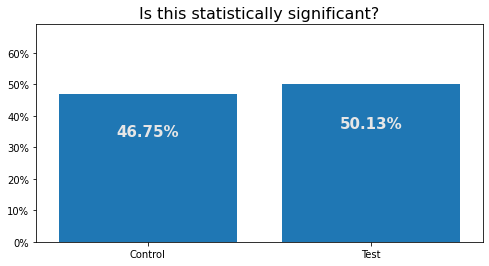

In [3]:
fig, ax = plt.subplots(figsize=(8,4))

x = [0,1]
y = [control_connected/control_installs, test_connected/test_installs]
ax.bar(x, y, align='center', width=.8)
ax.set_xticks(x)
ax.set_xticklabels(['Control', 'Test'])
xlim(-.5,1.5)
ylim(0, .69)

for xx, yy in zip(x,y):
    ax.text(xx, yy*.7, '%0.2f%%'%(100*yy),ha='center', va='bottom', 
            fontdict={'size':15,'weight':'bold','color':(0.9,.9,.9)})
    
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
# def perc(x, pos=0):
#     return '%0.0f%%'%(100*x)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos=0: '%0.0f%%'%(100.0*x)))
title('Is this statistically significant?', fontdict={'size':16})
pass
# fig.savefig('03.01 two samples.png', bbox_inches='tight', pad_inches=0.2 ,dpi=200)

<img src="assets/images/testing_3.png" style="width:100%" />

#### *Two Samples z-test for Proportions*

### $z = \frac{\hat{p_1}-\hat{p_2}}{\sqrt{\hat{p} (1-\hat{p}) (\frac{1}{n_1} + \frac{1}{n_2})}} $
where

- $\hat{p_1} = \frac{x_1}{n_1}, \hat{p_2} = \frac{x_2}{n_2} $
- $\hat{p} = \frac{x_1 + x_2}{n_1 + n_2}$

    - $x_1, x_2$ - number of successes in group 1 and 2
    - $n_1, n_2$ - number of observations in group 1 and 2

## Using statsmodels to calculate the z-statistic & p-value:

In [4]:
# using statsmodels
from statsmodels.stats.proportion import proportions_ztest
count = np.array([control_connected,test_connected])
nobs = np.array([control_installs, test_installs])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

 z-stat = -3.1481826186555577 
 p-value = 0.0016428902134483648


We can reject the null-hypothesis. 

Our second sign up form results in a better Facebook connection rate. 



## So what is the uplift?

Let's calculate the confidence interval from our uplift: 

#### $CI = (\hat{p_1} - \hat{p_2}) ± z_{critical} \cdot SE $ 

$SE = \sqrt{ \frac{\hat{p_1}(1-\hat{p_1})}{n_1} + \frac{\hat{p_2}(1-\hat{p_2})}{n_2} }  $

where

- $\hat{p_1}, \hat{p_2}$ - proportion in group 1 and 2


- $n_1, n_2$ - number of observations in group 1 and 2


In [5]:
def compute_standard_error_prop_two_samples(x1, n1, x2, n2, alpha=0.05):
    p1 = x1/n1
    p2 = x2/n2    
    se = p1*(1-p1)/n1 + p2*(1-p2)/n2
    return sqrt(se)
    
def zconf_interval_two_samples(x1, n1, x2, n2, alpha=0.05):
    p1 = x1/n1
    p2 = x2/n2    
    se = compute_standard_error_prop_two_samples(x1, n1, x2, n2)
    z_critical = stats.norm.ppf(1-0.5*alpha)
    return p2-p1-z_critical*se, p2-p1+z_critical*se

ci_low,ci_upp = zconf_interval_two_samples(control_connected, control_installs, 
                                           test_connected, test_installs)
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 95% Confidence Interval = ( 1.28% , 5.50% )


**So, our 95% Confidence Interval for the uplift is [1.28% , 5.50%]**